In [1]:
"""
Created on Mon Jan  2 23:57:51 2023

@author: Godzilla

Quantum Support Vector Machine (QSVM) for Quantum Phase Transitions (QPT)

The QSVM program is structured as following:

1- Obtain the parameters for the circuit used to computed the Kernel.
These parameters are used as Training Data for the SVM, and are obtained via VQE 
from another program and defines the Ground States (GS) 
of the Ising Hamiltonian (on the ansatz circuit EfficientSU2).

2- Computed the Kernel using the Fidelity.

3- Train the Support Vector Machines using the sklearn package.

4- Find the Jc by minimizing the distance function. In this step the VQE is
implemented in order to find the GS for a generic J, and evaluate his distance
from the hyperplane find by the trained SVM.

"""

#qsvm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import EfficientSU2
from qiskit import Aer
from qiskit.providers.aer import AerSimulator
from qiskit.algorithms.optimizers import COBYLA
from qiskit.opflow import X,Z,I
from qiskit.utils import QuantumInstance
from qiskit.algorithms import VQE
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info.operators import Operator
from sklearn import svm

#noise
from qiskit.providers.fake_provider import FakeToronto
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.aer.noise import depolarizing_error

#noise-affected backend
backend = FakeToronto()
sim_toronto = AerSimulator.from_backend(backend)

qubits_layout = [0,1,2,3,5,8]

#Parameters for the Ansatz circuit (number of times of the CX block)
reps = 1

backend_sv = AerSimulator(method='statevector')
quantum_instance = QuantumInstance(backend=backend_sv, seed_transpiler=1)
optimizer = COBYLA(maxiter=200, tol=0.01)
intermediate_info = dict()

In [2]:

def IBM_noise_model(N):
    
    noise_model_1 = NoiseModel()
    noise_model_2 = NoiseModel()
    noise_model_3 = NoiseModel()
    noise_model_4 = NoiseModel()
    
    prop = backend.properties()
    
    # According to several tests, gate_length turns out to be the same for x and sx and for each qubit
    # gate_error is the same for x and sx on the same qubit
    
    tg = prop.gate_length('x',qubits_layout[0]) 
    
    T1 = [prop.t1(j) for j in qubits_layout]
    T2 = [prop.t2(j) for j in qubits_layout]
    p = [prop.gate_error('x',[j]) for j in qubits_layout] 
    rout = [prop.readout_error(j) for j in qubits_layout]
    
    t_cnot = np.zeros((N,N))
    p_cnot = np.zeros((N,N))
    
    if (N > 1):
        for i in range(0,N):
            if (i == 0):
                t_cnot[0][1] = prop.gate_length('cx',[qubits_layout[0],qubits_layout[1]])
                p_cnot[0][1] = prop.gate_error('cx',[qubits_layout[0],qubits_layout[1]])
            if (i != 0 and i != N-1):
                t_cnot[i][i-1] = prop.gate_length('cx',[qubits_layout[i],qubits_layout[i-1]])
                p_cnot[i][i-1] = prop.gate_error('cx',[qubits_layout[i],qubits_layout[i-1]])
                t_cnot[i][i+1] = prop.gate_length('cx',[qubits_layout[i],qubits_layout[i+1]])
                p_cnot[i][i+1] = prop.gate_error('cx',[qubits_layout[i],qubits_layout[i+1]])
            if (i == N-1):
                t_cnot[i][i-1] = prop.gate_length('cx',[qubits_layout[i],qubits_layout[i-1]])
                p_cnot[i][i-1] = prop.gate_error('cx',[qubits_layout[i],qubits_layout[i-1]])
                
    
    #SINGLE QUBIT ERRORS
        
    for j in range(0,N):
        
        #single qubit depolarizing
        dep_1 = depolarizing_error(p[j],1)
        
        #single qubit thermal relaxation
        thermal_relax = thermal_relaxation_error(T1[j], T2[j], tg)
        
        #readout error
        readout = pauli_error([('X',rout[j]), ('I', 1 - rout[j])])
        
        #----------------------adding the errors to the corresponding noise models---------------------------------------------
        
        single_qubit_gate_error = dep_1.compose(thermal_relax)
        
        noise_model_1.add_quantum_error(single_qubit_gate_error, ["x","sx"],[qubits_layout[j]])
        noise_model_4.add_quantum_error(single_qubit_gate_error, ["x","sx"],[qubits_layout[j]])
        
        noise_model_2.add_quantum_error(readout, "measure",[qubits_layout[j]])
        noise_model_4.add_quantum_error(readout, "measure",[qubits_layout[j]])
        
        
     #TWO QUBITS ERRORS

    for j in range(0,N):
        for k in range(0,N):
            if (k == j+1 or k == j-1):
                
                #two qubits relaxation
                thermal_relax_j = thermal_relaxation_error(T1[j], T2[j], t_cnot[j][k])
                thermal_relax_k = thermal_relaxation_error(T1[k], T2[k], t_cnot[j][k])
                thermal_relax_jk = thermal_relax_k.tensor(thermal_relax_j)
   
                #two qubits depolarizing
                dep_2 = depolarizing_error(p_cnot[j][k],2)
                
                
                #-------adding the errors to the corresponding noise models-----------------------------------------------------
                
                two_qubits_gate_error = dep_2.compose(thermal_relax_jk)
                
                noise_model_3.add_quantum_error(two_qubits_gate_error, "cx",[qubits_layout[j],qubits_layout[k]])
                noise_model_4.add_quantum_error(two_qubits_gate_error, "cx",[qubits_layout[j],qubits_layout[k]])
    
    return noise_model_1, noise_model_2, noise_model_3, noise_model_4


In [21]:
def circuit(N):
    """Define the circuit for the Quantum Kernel"""

    qr = QuantumRegister(N)
    qc = QuantumCircuit(qr)
    GS1 = EfficientSU2(N, su2_gates=['ry'], reps=reps, entanglement='linear', insert_barriers=True, parameter_prefix='p1')
    GS2 = EfficientSU2(N, su2_gates=['ry'], reps=reps, entanglement='linear', insert_barriers=True, parameter_prefix='p2')
    
    qc.append(GS1,qr)
    qc.append(GS2.inverse(),qr)
    qc.measure_all(add_bits=True)

    return qc



def pre_bind_circuit(c, pi, pj):
    """bind the parameters to the circuit defined for the Quantum Kernel"""

    #p_{i} parameters from the GS_{i} and p_{j} parameters from the GS_{j}
    p = np.append(pi, pj)
    bind_dict = {c.parameters[i]: p[i] for i in range(c.num_parameters)}
    c = c.bind_parameters(bind_dict)

    #job_sim = backend_sim.run(transpile(qc, backend_sim), shots=nshots)
    #result_sim = job_sim.result()
    
    #counts = result_sim.get_counts(qc)
    
    #tqc = transpile(c, backend, initial_layout = qubits_layout, seed_transpiler = 5)
    
    tqc = transpile(c, sim_toronto, initial_layout = qubits_layout, seed_transpiler=5)

    return tqc

def bind_circuit(tqc):
    sim_noise_1 = AerSimulator(noise_model=noise_model_2, method='statevector')  
    result_1 = sim_noise_1.run(tqc, shots=nshots).result()
    counts = result_1.get_counts()
    return counts

"""def bind_circuit(tqc):
    
    result_toronto = sim_toronto.run(tqc).result()
    counts = result_toronto.get_counts()
    
    return counts"""
    
def kernel(p1, p2):
    """Quantum Kernel algorithm using Fidelity"""

    c = circuit(N)

    x = len(p1)
    y = len(p2)
    K = np.empty((x, y), dtype=np.float64, order='C')

    for i in range(x):
        for j in range(y):
            tqc = pre_bind_circuit(c, p1[i], p2[j])
            counts = bind_circuit(tqc)
            
            if i == j:
                K[i,j] = 1
            else:
                try:
                    K[i, j] = counts[N*'0'] / nshots
                    
                except KeyError:
                    #if counts[N*'0'] is zero, then the relative Key (N*'0') isn't present in the dictionary named 'counts'
                    K[i, j] = 0.
                    
    K = np.sqrt(K)

    return K



def distance(J):
    """distance function according to the paper.
    Pass only 'J'. The relative set of parameters 'p' will be
    compute by the VQE (callable via GS()) inside this function.
    The parameters 'p' will be used to evaluate the 'distance' from
    the SVM iperplane.
    """
    c = circuit(N)
    p = GS(N, J)
    d = 0
    b = 0
    for i in range(M):
        for j in range(M):
            b += al[i]*ys[i]*K[clf.support_[i], clf.support_[j]] - ys[j]
            
    b = b/M
    d += b
    for j in range(M):
        tqc = pre_bind_circuit(c, p, sv[j])
        counts = bind_circuit(tqc)
        try:
            d += al[j]*ys[j]*np.sqrt(counts[N*'0'] / nshots)
        except KeyError:
            d += 0

    return float(d)



def Hamiltonian(N, J):
    """The fans favorite Hamiltonian"""

    H = -J*(X^(I^N-2)^X) + (I^(N-1)^Z)
    for i in range(N-1):
        H += -J*((I^i)^(X^X)^(I^(N-2-i))) + ((I^i)^(Z)^(I^(N-i-1)))

    return H



def callback(nfev, parameters, energy, stddev):
    """Callback function required from the VQE to obtain
    the intermediate info, like the set of parameters of the
    optimized ansatz circuit.
    """
    
    intermediate_info['parameters'] = (parameters)
    



def GS(N, J):
    """Call the VQE to find the parameters that will defines the GS (on the Ansatz circuit)"""

    H = Hamiltonian(N, J)
    ansatz = EfficientSU2(N, su2_gates=['ry'], reps=reps, entanglement='linear', insert_barriers=True)
    np.random.seed(16)
    initial_point = np.random.random(N*(reps+1))

    local_vqe = VQE(ansatz=ansatz,
                    optimizer=optimizer,
                    initial_point=initial_point,
                    quantum_instance=quantum_instance,
                    callback=callback)

    local_result = local_vqe.compute_minimum_eigenvalue(H)
    par = intermediate_info['parameters']

    return par



def J_critical():
    """Minimize the distance function in order to find Jc"""

    a = int(len(sv_J) - 1)
    results = root_scalar(distance, bracket=(sv_J[0], sv_J[a]))

    if not results.converged:
        raise Exception(results.flag)
    else:
        return results.root



def save_JcVSN(Jc):
    """Hope you have enough money to buy some indulgences and be saved.
    Format: ( Jc_[i], N_[i+1] ) i = 0, ..., Nmax, step = 2. \n'
    """

    f = open(f'results/noisy/JcVSN_noisy.txt', 'a')

    f.write(str(round(Jc, 4)) + ', ')
    f.write(str(N) + ', ')

    f.write('\n')
    f.close()


In [ ]:
Nmin = 6
Nmax = 7
for N in range(Nmin, Nmax):    
    
    nshots = 1024
    

    #obtaining the data parameters for the circuit (computed by the VQE in another program)
    g = np.genfromtxt(f'dataset/dataset{N}.txt', delimiter=',')
    J_train = g[:, 0]
    p_train = g[:, 3:-1]
    #The following array is necessary for the data classification
    y_train = [1 if x > 1 else -1 for x in J_train]
    
    noise_model_1, noise_model_2, noise_model_3, noise_model_4 = IBM_noise_model(N)

   #compute the Quantum Kernel
    K = kernel(p_train, p_train)
    #Train the SVM for classification
    clf = svm.SVC(kernel=K, cache_size=1000)
    clf.fit(p_train, y_train)

    #support vectors info
    sv = p_train[clf.support_]
    sv_J = J_train[clf.support_]
    ys = np.reshape(y_train, (len(y_train), 1))[clf.support_]
    al = np.abs(clf.dual_coef_[0])
    M  = len(sv)

    #find J_{c}
    Jc = J_critical()
    #save_JcVSN(Jc)


In [22]:
Nmin = 6
Nmax = 7
noise = 2
for N in range(Nmin, Nmax):    
    
    nshots = 1024
    

    #obtaining the data parameters for the circuit (computed by the VQE in another program)
    g = np.genfromtxt(f'dataset/dataset{N}.txt', delimiter=',')
    J_train = g[13:37, 0]
    p_train = g[13:37, 3:-1]
    #The following array is necessary for the data classification
    y_train = [1 if x > 1 else -1 for x in J_train]
    
    noise_model_1, noise_model_2, noise_model_3, noise_model_4 = IBM_noise_model(N)

   #compute the Quantum Kernel
    K = kernel(p_train, p_train)
    #Train the SVM for classification
    clf = svm.SVC(kernel='precomputed', cache_size=1000)
    clf.fit(K, y_train)

    #support vectors info
    sv = p_train[clf.support_]
    sv_J = J_train[clf.support_]
    ys = np.reshape(y_train, (len(y_train), 1))[clf.support_]
    al = np.abs(clf.dual_coef_[0])
    M  = len(sv)

    #find J_{c}
    Jc = J_critical()
    print(Jc)

0.774856252040601


In [ ]:
def HarryPlotter_JcVSN():
    """Harry Plotter and the Quantum Phase Transitions"""

    file = np.genfromtxt('results/noisy/JcVSN_noisy.txt', delimiter=',')
    J = file[:,0]
    N = file[:,1]

    fig, ax = plt.subplots(figsize=(5,4), layout='constrained')

    ax.set_ylabel(r"$J_{c}$", size=15)
    ax.set_xlabel("N", size=15)
    ax.set_title(r"$J_{c}\; VS\; N$")

    ax.plot(N, J, c='midnightblue', linestyle='--', linewidth=1)
    ax.plot(N, np.ones(len(N)), c='dimgray', linestyle=':')
    ax.scatter(N, J, facecolor='None', edgecolor='midnightblue', s=50)
    plt.legend()
    plt.savefig('results/noisy/JcVSN_noisy.pdf', bbox_inches='tight')


In [23]:
def distance_vet(p):
    """distance function according to the paper.
    The parameters 'p' will be used to evaluate the 'distance' from
    the SVM iperplane.
    """
    c = circuit(N)
    d = 0
    b = 0
    for i in range(M):
        for j in range(M):
            b += al[i]*ys[i]*K[clf.support_[i], clf.support_[j]] - ys[j]
            
    b = b/M
    d += b
    for j in range(M):
        tqc = pre_bind_circuit(c, p, sv[j])
        counts = bind_circuit(tqc)
        try:
            d += al[j]*ys[j]*np.sqrt(counts[N*'0'] / nshots)
        except KeyError:
            d += 0

    return float(d)



def save_dVSJ():
    """From the ancient testament, he comes to save you and your data"""

    a = np.genfromtxt(f'dataset/tutto{N}.txt', delimiter=',')
    DeltaJ = a[:,0]
    par = a[:,3:-1]
    f = open(f'results/noisy/distVSJ{N}_noisy{noise}.txt','w')

    f.write(f'#Format d function: ( d(J)_[i], J_[i+1] ) i = 0, ..., {2*len(DeltaJ)-1}, step = 2; d + J = {2*len(DeltaJ)} data. \n')
    f.write(f'#Format SV: ( d(J_sv)_[i], J_sv_[i+1] ) i = {2*len(DeltaJ)}, ..., {2*len(DeltaJ) + 2*len(sv_J)-1}, step = 2; d + J = {2*len(sv_J)} data. \n')
    f.write(f'#N = {N} at the end. \n')

    for i in range(len(DeltaJ)):
        dJ = distance_vet(par[i])
        f.write(str(DeltaJ[i]) + ', ')
        f.write(str(round(dJ, 4)) + ', ')
    
    for i in range(M):
        f.write(str(sv_J[i]) + ', ')
        sv_d = distance_vet(sv[i])
        f.write(str(round(sv_d, 4)) + ', ')

    f.write(str(N))
    f.close()

save_dVSJ()

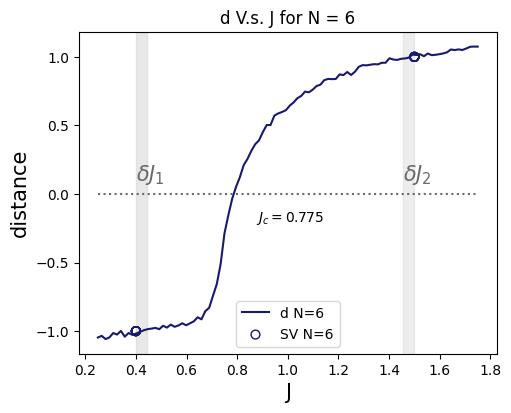

In [24]:
def HarryPlotter_dvsJ(N):
    """It's magick as Fuck, it can even plot your soul (but is not a psychotherapist)"""

    #Task: Rivedere questa funzione di plot perchè fa uso delle informazioni 'sv_J' che richiedono
    #di allenare la SVM ogni volta che si vuole fare il plot della d VS J

    a = np.genfromtxt(f'results/noisy/distVSJ{N}_noisy{noise}.txt', delimiter=',')
    lenSV = 2*len(sv_J)
    lenSV_e = lenSV + 1
    J = a[0:-lenSV_e:2]
    d = a[1:-(lenSV_e - 1):2]
    J_sv = a[-(lenSV + 1):-2:2]
    d_sv = a[-lenSV:-1:2]

    fig, ax = plt.subplots(figsize=(5,4), layout='constrained')

    ax.set_xlabel("J", size=15)
    ax.set_ylabel("distance", size=15)
    ax.set_title(f'd V.s. J for N = {N}')
    ax.text((Jc + 0.1), -0.2, r'$J_{c} =$' + str(round(Jc, 3)))

    ax.text(J_train[len(J_train)//2], 0.1, r'$\delta J_{1}$', c='dimgray', size=15)
    ax.text(J_train[0], 0.1, r'$\delta J_{2}$', c='dimgray', size=15)
    ax.axvspan(J_train[0], J_train[len(J_train)//2-1], alpha=0.5, color='gainsboro')
    ax.axvspan(J_train[len(J_train)//2], J_train[len(J_train)-1], alpha=0.5, color='lightgrey')

    ax.plot(J, d, c='midnightblue', label=f'd N={N}')
    ax.plot(J, np.zeros(len(J)), c='dimgray', linestyle=':')
    ax.scatter(np.round(sv_J, 1), np.round(d_sv, 0), facecolor='None', edgecolor='midnightblue', s=40, label=f'SV N={N}')
    plt.legend()
    plt.savefig(f'results/noisy/dVSJ{N}_noisy{noise}.pdf', bbox_inches='tight')

HarryPlotter_dvsJ(N)


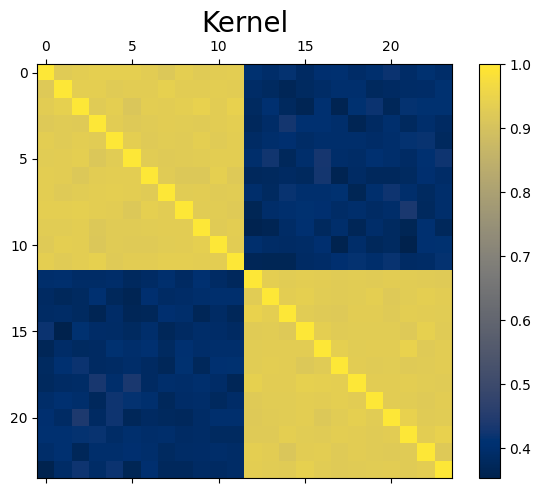

In [25]:
def plot_Kmatrix(K):
    """Plot the Kernel"""

    fig = plt.figure(layout='constrained')
    ax = fig.add_subplot()
    cax = ax.matshow(K, cmap=plt.cm.get_cmap('cividis', ), interpolation='nearest')
    fig.colorbar(cax)

    ax.set_title('Kernel', size=20)
    plt.savefig(f'results/noisy/Kernel{N}_noisy{noise}.pdf', bbox_inches='tight')
    
plot_Kmatrix(K)

In [15]:
k = open(f'results/noisy/kernel{N}_noisy{noise}.npy','wb')
np.save(k,K)